### Multi step model (encoder-decoder)

In [242]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [243]:
Paras = {
    'M0':['M0', 'e','Del_n' , 'sqrt_A'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot'],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [244]:
var_name = 'OMEGA_dot'
sat_var = 2

In [245]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()


<class 'pandas._libs.tslib.Timestamp'>


,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-0.00000000977520683609
2017-11-02 01:00:00,-0.00000000957752760144
2017-11-02 02:00:00,-0.00000000934083602756
2017-11-02 03:00:00,-0.00000000906539628995
2017-11-02 04:00:00,-0.00000000875378145918


In [295]:
df.columns
test = df.iloc[265:408,:]


# Enter number of entries per day

In [296]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-11 00:00:00'
#end_dt = '2017-11-15 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [248]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [249]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.head()

,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-0.00000000977520683609
2017-11-02 01:00:00,-0.00000000957752760144
2017-11-02 02:00:00,-0.00000000934083602756
2017-11-02 03:00:00,-0.00000000906539628995
2017-11-02 04:00:00,-0.00000000875378145918


In [250]:
train.tail(6)

,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-06 18:00:00,-0.00000000949201484960
2017-11-06 19:00:00,-0.00000000952032852389
2017-11-06 20:00:00,-0.00000000950916032499
2017-11-06 21:00:00,-0.00000000945877773141
2017-11-06 22:00:00,-0.00000000936944822168
2017-11-06 23:00:00,-0.00000000924143927430


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [251]:
from sklearn.preprocessing import StandardScaler

y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])

X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [336]:
import pickle
file_x = open(var_name+' X_scaler2_5D_OME_dot.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+' y_scalar2_5D_OME_dot.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [253]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [254]:
#train_inputs.dataframe

In [255]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [256]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 0.14071108129171694401 0.49293198617096850578   
2017-11-07 01:00:00 0.49293198617096850578 0.89979210028077249994   
2017-11-07 02:00:00 0.89979210028077249994 1.40530733235496274602   
2017-11-07 03:00:00 1.40530733235496274602 1.78114475329429322592   
2017-11-07 04:00:00 1.78114475329429322592 2.01247259003716960635   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 0.89979210028077249994 1.40530733235496274602   
2017-11-07 01:00:00 1.40530733235496274602 1.78114475329429322592   
2017-11-07 02:00:00 1.78114475329429322592 2.01247259003716960635   
2017-11-07 03:00:00 2.01247259003716960635 2.04384634676761844929   
2017-11-07 04:00:00 2.04384634676761844929 2.01598731575529210858   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.78114475329429322592 2.01247259003716960635   
2017-11-07 01:00:00 2.01247259003716960635 2.04384634676761844929   
2017-11-07 02:00:00 2.04384634676761844929 2.01598731575529210858   
2017-11-07 03:00:00 2.01598731575529210858 1.93154447146695740223   
2017-11-07 04:00:00 1.93154447146695740223 1.65501596662646299762   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 2.04384634676761844929 2.01598731575529210858   
2017-11-07 01:00:00 2.01598731575529210858 1.93154447146695740223   
2017-11-07 02:00:00 1.93154447146695740223 1.65501596662646299762   
2017-11-07 03:00:00 1.65501596662646299762 1.19734709801070104973   
2017-11-07 04:00:00 1.19734709801070104973 0.71865324034493660577   

tensor                                                              \
feature                                                              
time step                              t+9                    t+10   
Epoch_Time_of_Clock                                                  
2017-11-07 00:00:00 1.93154447146695740223  1.65501596662646299762   
2017-11-07 01:00:00 1.65501596662646299762  1.19734709801070104973   
2017-11-07 02:00:00 1.19734709801070104973  0.71865324034493660577   
2017-11-07 03:00:00 0.71865324034493660577  0.30352642614630975793   
2017-11-07 04:00:00 0.30352642614630975793 -0.04749514996851413040   

tensor                        ...                                 X  \
feature                       ...                         OMEGA_dot   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-07 00:00:00           ...           -0.29085090117642536933   
2017-11-07 01:00:00           ...           -0.50639472830363441158   
2017-11-07 02:00:00           ...           -0.66341341169468759364   
2017-11-07 03:00:00           ...           -0.76229554480740879807   
2017-11-07 04:00:00           ...           -0.80342972109961929839   

tensor                                                               \
feature                                                               
time step                               t-8                     t-7   
Epoch_Time_of_Clock         

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [257]:
#Image('./images/simple_encoder_decoder.png')

In [258]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [259]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 1000

In [260]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1) ,return_sequences=True))
model.add(LSTM(LATENT_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [261]:
model.compile(optimizer='RMSprop', loss='mse')

In [262]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 24, 64)            16896     
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                33024     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_7 (Flatten)          (None, 24)                0         
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [263]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [264]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [265]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 72 samples
Epoch 1/1000
73/73 [==============================] - 3s 36ms/step - loss: 1.0041 - val_loss: 1.0493
Epoch 2/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.9182 - val_loss: 1.0353
Epoch 3/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.8977 - val_loss: 0.9830
Epoch 4/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.8224 - val_loss: 0.8988
Epoch 5/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.7724 - val_loss: 0.8036
Epoch 6/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.6673 - val_loss: 0.7295
Epoch 7/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.6523 - val_loss: 0.7045
Epoch 8/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5425 - val_loss: 0.6483
Epoch 9/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.4728 - val_loss: 0.9438
Epoch 10/1000
73/73 [==============================] - 

73/73 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.1932
Epoch 162/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.1806
Epoch 163/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.1861
Epoch 164/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.2285
Epoch 165/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.2064
Epoch 166/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.1555
Epoch 167/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.2427
Epoch 168/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.1611
Epoch 169/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.2032
Epoch 170/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.1535
Epoch 322/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.1803
Epoch 323/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.1991
Epoch 324/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.1588
Epoch 325/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1966
Epoch 326/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0303 - val_loss: 0.1139
Epoch 327/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.1958
Epoch 328/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.1384
Epoch 329/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1488
Epoch 330/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.1360
Epoch 482/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.1468
Epoch 483/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.1724
Epoch 484/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.1250
Epoch 485/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.1709
Epoch 486/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.1094
Epoch 487/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1684
Epoch 488/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.1291
Epoch 489/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0194 - val_loss: 0.1461
Epoch 490/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.1386
Epoch 642/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.1316
Epoch 643/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.1429
Epoch 644/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.1099
Epoch 645/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 0.1612
Epoch 646/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.1152
Epoch 647/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.1653
Epoch 648/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.1139
Epoch 649/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.1194
Epoch 650/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.1621
Epoch 802/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0201 - val_loss: 0.0959
Epoch 803/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1511
Epoch 804/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.1130
Epoch 805/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.1320
Epoch 806/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.1096
Epoch 807/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.1258
Epoch 808/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.1206
Epoch 809/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.1620
Epoch 810/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.1145
Epoch 962/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.1188
Epoch 963/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.1560
Epoch 964/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.1202
Epoch 965/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.1576
Epoch 966/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0959
Epoch 967/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.1423
Epoch 968/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.1087
Epoch 969/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.1304
Epoch 970/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.

In [266]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [267]:
model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
72/72 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 0.2621
Epoch 3/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1230
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1213
Epoch 5/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1203
Epoch 6/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1201
Epoch 7/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1196
Epoch 8/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1188
Epoch 9/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1177
Epoch 10/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1163
Epoch 11/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1147
Epoch 12/100
72/72 [==============================] - 0s 2ms/step - loss: 0.1128
Epoch 13/100
72/72 [=================

## Evaluate the model

In [297]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:end_dt][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.33500514781107137985 -0.04749514996851413040   
2017-11-14 01:00:00 -0.04749514996851413040  0.32803331121033646456   
2017-11-14 02:00:00  0.32803331121033646456  0.71428778670423287434   
2017-11-14 03:00:00  0.71428778670423287434  1.05926195957457713881   
2017-11-14 04:00:00  1.05926195957457713881  1.22118133280867247059   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 0.32803331121033646456 0.71428778670423287434   
2017-11-14 01:00:00 0.71428778670423287434 1.05926195957457713881   
2017-11-14 02:00:00 1.05926195957457713881 1.22118133280867247059   
2017-11-14 03:00:00 1.22118133280867247059 1.19273531193175696963   
2017-11-14 04:00:00 1.19273531193175696963 1.09942999377016903395   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 1.05926195957457713881 1.22118133280867247059   
2017-11-14 01:00:00 1.22118133280867247059 1.19273531193175696963   
2017-11-14 02:00:00 1.19273531193175696963 1.09942999377016903395   
2017-11-14 03:00:00 1.09942999377016903395 0.96332459895237088077   
2017-11-14 04:00:00 0.96332459895237088077 0.70140826416528545550   

tensor                                                              \
feature                                                              
time step                              t+7                     t+8   
Epoch_Time_of_Clock                                                  
2017-11-14 00:00:00 1.19273531193175696963  1.09942999377016903395   
2017-11-14 01:00:00 1.09942999377016903395  0.96332459895237088077   
2017-11-14 02:00:00 0.96332459895237088077  0.70140826416528545550   
2017-11-14 03:00:00 0.70140826416528545550  0.32615303693918301642   
2017-11-14 04:00:00 0.32615303693918301642 -0.04749514996851413040   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00  0.96332459895237088077  0.70140826416528545550   
2017-11-14 01:00:00  0.70140826416528545550  0.32615303693918301642   
2017-11-14 02:00:00  0.32615303693918301642 -0.04749514996851413040   
2017-11-14 03:00:00 -0.04749514996851413040 -0.37568496094050468637   
2017-11-14 04:00:00 -0.37568496094050468637 -0.64304871699996779544   

tensor                        ...                                 X  \
feature                       ...                         OMEGA_dot   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...           -0.93065690156849911752   
2017-11-14 01:00:00           ...           -1.10080417998033053273   
2017-11-14 02:00:00           ...           -1.21574312915980842220   
2017-11-14 03:00:00           ...           -1.27703416807841030334   
2017-11-14 04:00:00           ...           -1.28623771573667489143   

tensor                                                               \
feature                                                               
time step                               t-8                    

In [298]:
test_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.33500514781107137985 -0.04749514996851413040   
2017-11-14 01:00:00 -0.04749514996851413040  0.32803331121033646456   
2017-11-14 02:00:00  0.32803331121033646456  0.71428778670423287434   
2017-11-14 03:00:00  0.71428778670423287434  1.05926195957457713881   
2017-11-14 04:00:00  1.05926195957457713881  1.22118133280867247059   
2017-11-14 05:00:00  1.22118133280867247059  1.19273531193175696963   
2017-11-14 06:00:00  1.19273531193175696963  1.09942999377016903395   
2017-11-14 07:00:00  1.09942999377016903395  0.96332459895237088077   
2017-11-14 08:00:00  0.96332459895237088077  0.70140826416528545550   
2017-11-14 09:00:00  0.70140826416528545550  0.32615303693918301642   
2017-11-14 10:00:00  0.32615303693918301642 -0.04749514996851413040   
2017-11-14 11:00:00 -0.04749514996851413040 -0.37568496094050468637   
2017-11-14 12:00:00 -0.37568496094050468637 -0.64304871699996779544   
2017-11-14 13:00:00 -0.64304871699996779544 -0.85547013537058791410   
2017-11-14 14:00:00 -0.85547013537058791410 -1.01413601029847377788   
2017-11-14 15:00:00 -1.01413601029847377788 -1.12023313600068541440   
2017-11-14 16:00:00 -1.12023313600068541440 -1.17494830669427896552   
2017-11-14 17:00:00 -1.17494830669427896552 -1.17946831659631423683   
2017-11-14 18:00:00 -1.17946831659631423683 -1.13497995993837852424   
2017-11-14 19:00:00 -1.13497995993837852424 -1.04267003093752497200   
2017-11-14 20:00:00 -1.04267003093752497200 -0.90372532381081616126   
2017-11-14 21:00:00 -0.90372532381081616126 -0.71933263277530545832   
2017-11-14 22:00:00 -0.71933263277530545832 -0.49067875207711098007   
2017-11-14 23:00:00 -0.49067875207711098007 -0.21895047591875707593   
2017-11-15 00:00:00 -0.21895047591875707593  0.09466540146816218582   
2017-11-15 01:00:00  0.09466540146816218582  0.44898208588112492601   
2017-11-15 02:00:00  0.44898208588112492601  0.83964953951184229108   
2017-11-15 03:00:00  0.83964953951184229108  1.18956312249132434289   
2017-11-15 04:00:00  1.18956312249132434289  1.40530733235496274602   
2017-11-15 05:00:00  1.40530733235496274602  1.32087715502241476173   
...                                     ...                     ...   
2017-11-16 18:00:00 -0.82861504452554479716 -0.77782247689786765399   
2017-11-16 19:00:00 -0.77782247689786765399 -0.68102144873532100000   
2017-11-16 20:00:00 -0.68102144873532100000 -0.53906116065829468020   
2017-11-16 21:00:00 -0.53906116065829468020 -0.35279081327264949497   
2017-11-16 22:00:00 -0.35279081327264949497 -0.12305960718424864553   
2017-11-16 23:00:00 -0.12305960718424864553  0.14928325703010486558   
2017-11-17 00:00:00  0.14928325703010486558  0.46338857875001654429   
2017-11-17 01:00:00  0.46338857875001654429  0.81840715738415448222   
2017-11-17 02:00:00  0.81840715738415448222  1.21035565823367763372   
2017-11-17 03:00:00  1.21035565823367763372  1.56316566292614544942   
2017-11-17 04:00:00  1.56316566292614544942  1.73394503050644011033   
2017-11-17 05:00:00  1.73394503050644011033  1.69767879398128451740   
2017-11-17 06:00:00  1.69767879398128451740  1.54796165933561646888   
2017-11-17 07:00:00  1.54796165933561646888  1.32841208887390038740   
2017-11-17 08:00:00  1.32841208887390038740  1.02916982803134482438   
2017-11-17 09:00:00  1.02916982803134482438  0.67842741233001946366   
2017-11-17 10:00:00  0.67842741233001946366  0.34334618915546943896   
2017-11-17 11:00:00  0.34334618915546943896  0.05867728937758159846   
2017-11-17 12:00:00  0.05867728937758159846 -0.17499726074043489565   
2017-11-17 13:00:00 -0.17499726074043489565 -0.35858104817723879254   
2017-11-17 14:00:00 -0.35858104817723879254 -0.49297765988243807955   
2017-11-17 15:00:00 -0.4

In [300]:
test_inputs.dataframe.shape

(96, 48)

In [301]:
predictions = model.predict(test_inputs['X'])

In [302]:
predictions

array([[-0.8900159 , -0.30699697,  0.0718559 , ...,  0.96953815,
         0.9494998 ,  0.9306598 ],
       [-0.59082997, -0.02457769,  0.34801617, ...,  0.6653469 ,
         0.63376516,  0.60358256],
       [-0.28638306,  0.20970134,  0.52282906, ...,  0.2231604 ,
         0.1893303 ,  0.15928854],
       ...,
       [-0.16521913, -0.05440329,  0.16540731, ..., -0.9801845 ,
        -0.8864463 , -0.728399  ],
       [ 0.05422975,  0.27898765,  0.595263  , ..., -0.82080674,
        -0.6878603 , -0.5011163 ],
       [ 0.28025535,  0.62125456,  1.026844  , ..., -0.6488487 ,
        -0.47628677, -0.26239297]], dtype=float32)

In [303]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-14 00:00:00  t+1 -0.00000000957992793956 -0.00000000919790026610
1 2017-11-14 01:00:00  t+1 -0.00000000937399083846 -0.00000000900000000000
2 2017-11-14 02:00:00  t+1 -0.00000000916443247829 -0.00000000874151444140
3 2017-11-14 03:00:00  t+1 -0.00000000896360320994 -0.00000000847564590098
4 2017-11-14 04:00:00  t+1 -0.00000000879226256149 -0.00000000823819161723
               timestamp     h              prediction                  actual
2299 2017-11-17 19:00:00  t+24 -0.00000000965855239553 -0.00000000923309127418
2300 2017-11-17 20:00:00  t+24 -0.00000000960720341822 -0.00000000919509634570
2301 2017-11-17 21:00:00  t+24 -0.00000000946868300201 -0.00000000912768453682
2302 2017-11-17 22:00:00  t+24 -0.00000000931223867755 -0.00000000900000000000
2303 2017-11-17 23:00:00  t+24 -0.00000000914791950082 -0.00000000890752722203
(2304, 4)


In [304]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    -0.02852753370615188078
t+10   -0.02742525664654022963
t+11   -0.03163749332700745848
t+12   -0.03619501156316016349
t+13   -0.04095404414083867600
t+14   -0.04580070491347552203
t+15   -0.05135903415852629411
t+16   -0.05701608398570434666
t+17   -0.06300830973545822056
t+18   -0.06877630737166091912
t+19   -0.07412036885807517239
t+2    -0.02567906035819169860
t+20   -0.07903654954987580916
t+21   -0.08287281421544202831
t+22   -0.08481329403656585886
t+23   -0.08596366223023872710
t+24   -0.08481750997114706481
t+3    -0.02372710050985196717
t+4    -0.02086262912490459420
t+5    -0.01844046604845235235
t+6    -0.01743768462792127938
t+7    -0.01794164320858453524
t+8    -0.02008503396798941645
t+9    -0.02375487721713289910
Name: APE, dtype: float64

# Predictions

In [305]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

4.100594421762091e-10

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

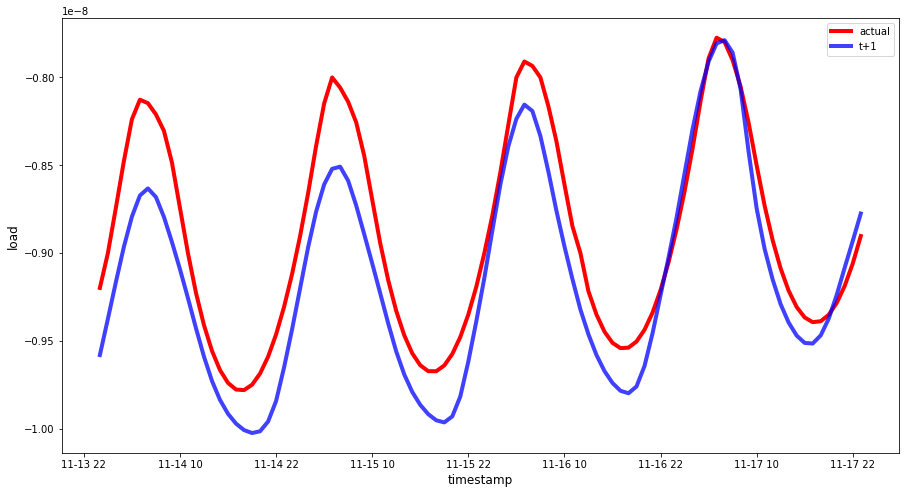

In [337]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
#ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
#ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [307]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]


In [308]:
new_df = pd.DataFrame()

In [309]:
columns = [Paras[var_name]] 

In [310]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [311]:
new_df = new_df.dropna( how = 'any')

In [312]:
new_df

,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-21 00:00:00,-0.00000000851895451729
2017-11-21 01:00:00,-0.00000000836287991553
2017-11-21 02:00:00,-0.00000000818642722636
2017-11-21 03:00:00,-0.00000000800000000000
2017-11-21 04:00:00,-0.00000000777776760905
2017-11-21 05:00:00,-0.00000000758390547225
2017-11-21 06:00:00,-0.00000000747674242305
2017-11-21 07:00:00,-0.00000000748801923454
2017-11-21 08:00:00,-0.00000000761091060503


In [313]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [314]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [315]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [316]:
new_df.index= date

In [317]:
new_df.columns

Index(['OMEGA_dot'], dtype='object')

In [318]:
print(new_df)
print(new_df.columns)

                                  OMEGA_dot
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -0.00000000851895451729
2017-11-22 01:00:00 -0.00000000836287991553
2017-11-22 02:00:00 -0.00000000818642722636
2017-11-22 03:00:00 -0.00000000800000000000
2017-11-22 04:00:00 -0.00000000777776760905
2017-11-22 05:00:00 -0.00000000758390547225
2017-11-22 06:00:00 -0.00000000747674242305
2017-11-22 07:00:00 -0.00000000748801923454
2017-11-22 08:00:00 -0.00000000761091060503
2017-11-22 09:00:00 -0.00000000781165426851
2017-11-22 10:00:00 -0.00000000800000000000
2017-11-22 11:00:00 -0.00000000823743187372
2017-11-22 12:00:00 -0.00000000841629087807
2017-11-22 13:00:00 -0.00000000856423961712
2017-11-22 14:00:00 -0.00000000868211486023
2017-11-22 15:00:00 -0.00000000877098795925
2017-11-22 16:00:00 -0.00000000883193026600
2017-11-22 17:00:00 -0.00000000886601313235
2017-11-22 18:00:00 -0.00000000887430791012
2017-11-22 19:00:00 -0.00000000885788595117
2017-11-22 20:00:00 -0.000000008

In [319]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[Paras[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), Paras[var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                 OMEGA_dot
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 0.65136892142306768161
2017-11-22 01:00:00 0.87811449028764543279
2017-11-22 02:00:00 1.13446539512647248671
2017-11-22 03:00:00 1.40530733235496274602
2017-11-22 04:00:00 1.72816710157980502061


In [320]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                         \
feature                          OMEGA_dot                          
time step                             t-23                   t-22   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 0.65136892142306768161 0.87811449028764543279   

tensor                                                             \
feature                                                             
time step                             t-21                   t-20   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 1.13446539512647248671 1.40530733235496274602   

tensor                                                             \
feature                                                             
time step                             t-19                   t-18   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 1.7281671015

In [321]:
predictions = model.predict(inputs['X'])

In [322]:
predictions

array([[ 0.2705225  ,  0.44467944 ,  0.5463613  ,  0.6035408  ,
         0.6292668  ,  0.6290099  ,  0.6051212  ,  0.55929863 ,
         0.4939327  ,  0.4127072  ,  0.320663   ,  0.22383897 ,
         0.12863086 ,  0.04120782 , -0.032651946, -0.08731775 ,
        -0.117116734, -0.116717145, -0.082098916, -0.011463596,
         0.09475133 ,  0.23514079 ,  0.40940058 ,  0.61902    ]],
      dtype=float32)

In [323]:
print(predictions.shape)


(1, 24)


In [324]:
results = predictions[-1, :]

In [325]:
results

array([ 0.2705225  ,  0.44467944 ,  0.5463613  ,  0.6035408  ,
        0.6292668  ,  0.6290099  ,  0.6051212  ,  0.55929863 ,
        0.4939327  ,  0.4127072  ,  0.320663   ,  0.22383897 ,
        0.12863086 ,  0.04120782 , -0.032651946, -0.08731775 ,
       -0.117116734, -0.116717145, -0.082098916, -0.011463596,
        0.09475133 ,  0.23514079 ,  0.40940058 ,  0.61902    ],
      dtype=float32)

In [326]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,OMEGA_dot
0,0.27052250504493713379
1,0.44467943906784057617
2,0.54636132717132568359
3,0.60354077816009521484
4,0.62926679849624633789
5,0.62900990247726440430
6,0.60512119531631469727
7,0.55929863452911376953
8,0.49393269419670104980
9,0.41270720958709716797


In [327]:
res_df.index = date
res_df

,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-22 00:00:00,0.27052250504493713379
2017-11-22 01:00:00,0.44467943906784057617
2017-11-22 02:00:00,0.54636132717132568359
2017-11-22 03:00:00,0.60354077816009521484
2017-11-22 04:00:00,0.62926679849624633789
2017-11-22 05:00:00,0.62900990247726440430
2017-11-22 06:00:00,0.60512119531631469727
2017-11-22 07:00:00,0.55929863452911376953
2017-11-22 08:00:00,0.49393269419670104980


In [328]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [330]:
# final generated ouput
res_df['actual'] = Actual
res_df

,OMEGA_dot,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,-0.00000000878110029134,-0.00000000844252241989
2017-11-22 01:00:00,-0.00000000866122373822,-0.00000000830029842923
2017-11-22 02:00:00,-0.00000000859123350239,-0.00000000814085716473
2017-11-22 03:00:00,-0.00000000855187565207,-0.00000000800000000000
2017-11-22 04:00:00,-0.00000000853416803892,-0.00000000777580986875
2017-11-22 05:00:00,-0.00000000853434478643,-0.00000000760238772032
2017-11-22 06:00:00,-0.00000000855078763351,-0.00000000750163638396
2017-11-22 07:00:00,-0.00000000858232862555,-0.00000000751032424326
2017-11-22 08:00:00,-0.00000000862732196794,-0.00000000764204786484


In [332]:
res_df.to_csv('SA2_OMEGA_dot.csv')

In [331]:
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(res_df['OMEGA_dot'], res_df['actual'])
a

4.694561527107474e-10